# <font color='green'>Syndrome extraction cycle in the surface code</font>

In [1]:
import numpy as np
import random
import cirq
import matplotlib.pyplot as plotter
from matplotlib.patches import Circle, Rectangle, FancyBboxPatch
import matplotlib.patches as mpatches
from surfacecodeviz import PlanarSurfaceCode

In the previous chapter, we defined the stabilizers for the surface code. Similar to the lessons learned from repetition codes, the data qubits of the surface code can undergo errors (represented by Paulis). The syndromes associated with these errors are obtained by measuring these stabilizers using syndrome extraction circuits.

## <font color='blue'>Logical operators</font>
Before we start building, we need to introduce one more important concept — logical operators, denoted as $X_{\textrm{L}}$ and $Z_{\textrm{L}}$.

In the 2D surface code, there can be chains of errors that run horizontally or vertically. If these error chains run along the entire length of the surface code, then they are not detected by the code, as they do not trigger any of the surrounding ancilla qubits. In the literature, this observation is commonly described by noting that these error chains are not part of the stabilizer group, but they still stabilize the code. These error chains incidentally also happen to be the logical operators of the code, analogous to the $X$ and $Z$ operators of single qubits.

For example, consider the distance-3 surface code below.

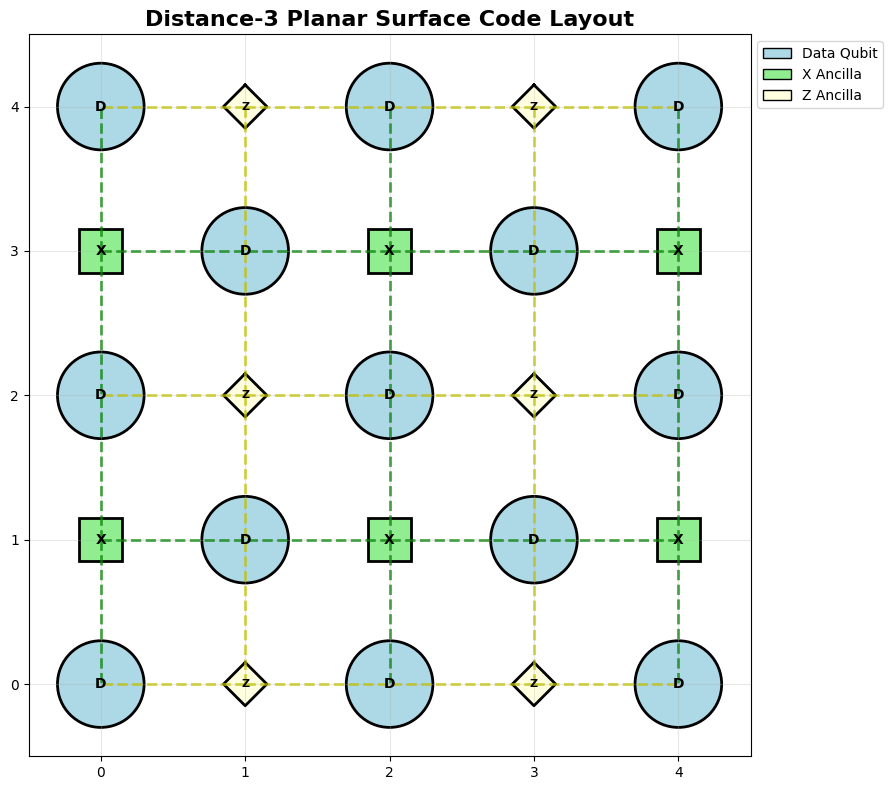

Surface Code Distance: 3
Total qubits: 25
Data qubits: 13
X ancillas: 6
Z ancillas: 6
X stabilizers: 6
Z stabilizers: 6


In [2]:
PlanarSurfaceCode(distance=3).visualize_layout()

The logical operator $X_{\textrm{L}} = X_{1} \otimes X_{2} \otimes X_{3}$ runs horizontally from one end of the $X$-boundary to the other end (eg rows 0, 2 and 4). Every $Z$ ancilla interacts with two data qubits that have $X$ errors, so the logical operator commutes with all $Z$ stabilizers in the chain. Hence, applying $X_{\textrm{L}}$ to the qubit state maps it to a different state outside the codespace, but still stabilized by the codespace — i.e., it produces the same measurement outcome as the original state.

These types of errors are known as logical errors in the surface code, analogous to the repetition code setting. Logical errors are fatal, as they can alter the state of the quantum information stored in the code without being tracked by the stabilizers — and therefore cannot be detected or corrected.

The length of the chain of these logical operators is directly proportional to the code distance. This is why surface codes with larger distances are favorable: they make such errors increasingly improbable. However, we will later learn that simply increasing the distance of a surface code is not always the complete solution. But for now, let's begin building our syndrome extraction circuits.

## <font color='blue'>Extracting syndromes</font>

In this section, we will introduce errors to our qubits, and measure the corresponding syndromes using syndrome extraction circuits.

We will add on the surface code class we built in the previous notebook by creating a function that generates syndrome extraction circuits. We will also introduce noise to the qubits to be able to 
observe the syndrome extraction circuits in action.

First, let's break down the syndrome extraction. As we learnt previously we are measuring the stabilizers $Z\otimes Z\otimes Z\otimes Z$ and $X\otimes X\otimes X\otimes X$. This measurement is done by entangling the ancilla qubits with the data qubits. We are interested in the final measurement being $+1,-1$, where the latter value shows that an error has occurred. 

The procedure, similar to the repetition code setting, is as follows:

1. Initialize the ancilla qubits in state $\vert0\rangle$ to measure Z-stabilizers and $\vert+\rangle$ to measure X-stabilizers.
2. Entangle the ancilla qubits with the data qubits:
    a. Measure parity of $ZZZZ$ to find bit-flip errors. CNOT gates from ancilla (control) to data qubits (target). 
    b. Measure parity of $XXXX$ to find phase-flip errors. CNOT gates to ancilla (target) from data qubits (control). Additionally, apply Hadamard gates before and after the series of CNOT gates. 

This syndrome extraction circuit is run for several rounds to allow tracking of errors over time. So essentially, the problem becomes 3D -- 2D in space + 1D in time across the repeated rounds. The multiple rounds of syndromes also help to distinguish between data qubit errors and measurement errors.

This brings us to the type of errors we can expect in a syndrome extraction cyle, namely:
1. Data qubit errors,
2. Measurement errors (at the end of the syndrome extraction), and
3. Hook errors (ancilla errors that cause more than one data qubit error). 

The tracking of these errors over time (multiple rounds of syndrome extraction) is essential to the construction of decoder graph which is fed to a decoder. Using an appropriate decoder, the surface code can detect where the error occurred, and apply necessary corrections. We will tackle the decoding process in the next chapter.

In [3]:
class SyndromeExtraction(PlanarSurfaceCode):
    """
    Implement syndrome extraction circuits.
    Create separate circuits for X and Z syndrome extraction.

    Returns:
    --------
    - X syndrome extraction circuit
    - Z syndrome extraction circuit
    - Circuit depth and total operations for both circuits
    - No. of parallel CNOT layers
    """
    
    def __init__(self, distance):
        super().__init__(distance)
        self.x_syndrome_circuit = None
        self.z_syndrome_circuit = None
        
    def create_x_syndrome_circuit(self):
        """
        Create X syndrome extraction circuit.
        The syndrome extraction circuit is optimized to
        implement conflict-free CNOT gates.
        """
        circuit = cirq.Circuit()
        
        # Reset ancilla qubits to |0>
        reset_ops = []
        for ancilla_pos in self.x_ancillas:
            ancilla = self.x_ancillas[ancilla_pos]
            reset_ops.append(cirq.reset(ancilla))
        if reset_ops:
            circuit.append(reset_ops)
        
        # Hadamard gates on X ancillas to prepare |+> state
        h_ops = []
        for ancilla_pos in self.x_ancillas:
            ancilla = self.x_ancillas[ancilla_pos]
            h_ops.append(cirq.H(ancilla))
        if h_ops:
            circuit.append(h_ops)
        
        # CNOT gates organized to avoid conflicts
        # organized layers to ensure no qubit is involved in multiple operations
        cnot_layers = self._organize_x_cnots()
        
        for layer in cnot_layers:
            if layer:
                circuit.append(layer)
        
        # Final Hadamard gates on X ancillas
        final_h_ops = []
        for ancilla_pos in self.x_ancillas:
            ancilla = self.x_ancillas[ancilla_pos]
            final_h_ops.append(cirq.H(ancilla))
        if final_h_ops:
            circuit.append(final_h_ops)
        
        # Measurement of X ancillas
        measure_ops = []
        for ancilla_pos in self.x_ancillas:
            ancilla = self.x_ancillas[ancilla_pos]
            measure_ops.append(cirq.measure(ancilla, key=f'x_anc_{ancilla_pos}'))
        if measure_ops:
            circuit.append(measure_ops)
        
        self.x_syndrome_circuit = circuit
        return circuit
    
    def create_z_syndrome_circuit(self):
        """
        Create Z syndrome extraction circuit.
        The syndrome extraction circuit is optimized to
        implement conflict-free CNOT gates.
        
        """
        circuit = cirq.Circuit()
        
        # Reset ancilla qubits to |0>
        reset_ops = []
        for ancilla_pos in self.z_ancillas:
            ancilla = self.z_ancillas[ancilla_pos]
            reset_ops.append(cirq.reset(ancilla))
        if reset_ops:
            circuit.append(reset_ops)
        
        # CNOT gates organized to avoid conflicts
        # organized layers to ensure no qubit is involved in multiple operations
        cnot_layers = self._organize_z_cnots()
        
        for layer in cnot_layers:
            if layer:
                circuit.append(layer)
        
        # Measurement of Z ancillas
        measure_ops = []
        for ancilla_pos in self.z_ancillas:
            ancilla = self.z_ancillas[ancilla_pos]
            measure_ops.append(cirq.measure(ancilla, key=f'z_anc_{ancilla_pos}'))
        if measure_ops:
            circuit.append(measure_ops)
        
        self.z_syndrome_circuit = circuit
        return circuit
    
    def _organize_x_cnots(self):
        """
        Organize CNOT gates of the x-stabilizer measurement into conflict-free layers.
        """
        layers = []
        remaining_cnots = []
        
        # Collect all CNOT operations for X stabilizers
        for ancilla_pos, data_positions in self.x_stabilizers.items():
            ancilla = self.x_ancillas[ancilla_pos]
            for data_pos in data_positions:
                data_qubit = self.data_qubits[data_pos]
                remaining_cnots.append(cirq.CNOT(ancilla, data_qubit))
        
        # avoid conflicts
        while remaining_cnots:
            current_layer = []
            used_qubits = set()
            
            i = 0
            while i < len(remaining_cnots):
                cnot = remaining_cnots[i]
                control, target = cnot.qubits
                
                # Check if any qubit in this CNOT is already used in current layer
                if control not in used_qubits and target not in used_qubits:
                    current_layer.append(cnot)
                    used_qubits.add(control)
                    used_qubits.add(target)
                    remaining_cnots.pop(i)
                else:
                    i += 1
            
            if current_layer:
                layers.append(current_layer)
        
        return layers
    
    def _organize_z_cnots(self):
        """
        Organize CNOT gates of the z-stabiliser measurement into conflict-free layers.
        """
        layers = []
        remaining_cnots = []
        
        # Collect all CNOT operations for Z stabilizers
        for ancilla_pos, data_positions in self.z_stabilizers.items():
            ancilla = self.z_ancillas[ancilla_pos]
            for data_pos in data_positions:
                data_qubit = self.data_qubits[data_pos]
                remaining_cnots.append(cirq.CNOT(data_qubit, ancilla))
        
        # avoid conflicts
        while remaining_cnots:
            current_layer = []
            used_qubits = set()
            
            i = 0
            while i < len(remaining_cnots):
                cnot = remaining_cnots[i]
                control, target = cnot.qubits
                
                # Check if any qubit in this CNOT is already used in current layer
                if control not in used_qubits and target not in used_qubits:
                    current_layer.append(cnot)
                    used_qubits.add(control)
                    used_qubits.add(target)
                    remaining_cnots.pop(i)
                else:
                    i += 1
            
            if current_layer:
                layers.append(current_layer)
        
        return layers
    
    def print_syndrome_circuits(self):
        """
        Print both X and Z syndrome extraction circuits.
        """
        print("\n" + "="*60)
        print("X-SYNDROME EXTRACTION CIRCUIT")
        print("="*60)
        
        if self.x_syndrome_circuit is None:
            self.create_x_syndrome_circuit()
        
        print(f"Circuit depth: {len(self.x_syndrome_circuit)}")
        print(f"Total operations: {sum(len(moment) for moment in self.x_syndrome_circuit)}")
        print("\nCircuit:")
        print(self.x_syndrome_circuit)
        
        print("\n" + "="*60)
        print("Z SYNDROME EXTRACTION CIRCUIT")
        print("="*60)
        
        if self.z_syndrome_circuit is None:
            self.create_z_syndrome_circuit()
        
        print(f"Circuit depth: {len(self.z_syndrome_circuit)}")
        print(f"Total operations: {sum(len(moment) for moment in self.z_syndrome_circuit)}")
        print("\nCircuit:")
        print(self.z_syndrome_circuit)
        
        # Analyze circuit efficiency
        print("\n" + "="*60)
        print("CIRCUIT ANALYSIS")
        print("="*60)
        
        x_cnot_layers = self._organize_x_cnots()
        z_cnot_layers = self._organize_z_cnots()
        
        print(f"X syndrome CNOT layers: {len(x_cnot_layers)}")
        print(f"Z syndrome CNOT layers: {len(z_cnot_layers)}")
        
        for i, layer in enumerate(x_cnot_layers):
            print(f"  X Layer {i+1}: {len(layer)} parallel CNOTs")
        
        for i, layer in enumerate(z_cnot_layers):
            print(f"  Z Layer {i+1}: {len(layer)} parallel CNOTs")
        
        print(f"\nTotal X stabilizers measured: {len(self.x_stabilizers)}")
        print(f"Total Z stabilizers measured: {len(self.z_stabilizers)}")

### <font color='red'>Syndrome extraction circuits for distance-3 surface codes</font>

In [4]:
syndrome_extractor = SyndromeExtraction(distance = 3)
syndrome_extractor.print_syndrome_circuits()


X-SYNDROME EXTRACTION CIRCUIT
Circuit depth: 8
Total operations: 44

Circuit:
                   ┌───┐   ┌───┐
(0, 0): ────────────X──────────────────────────────────────────────────────────────
                    │
(0, 2): ────────────┼X─────────────────────────────────────────────────────────────
                    ││
(0, 4): ────────────┼┼X────────────────────────────────────────────────────────────
                    │││
(1, 0): ───R───H────@┼┼─────@──────@───H───M('x_anc_(1, 0)')───────────────────────
                     ││     │      │
(1, 1): ─────────────┼┼─────┼──────X───X───────────────────────────────────────────
                     ││     │          │
(1, 2): ───R───H─────@┼─────┼@─────@───@───H───────────────────M('x_anc_(1, 2)')───
                      │     ││     │
(1, 3): ──────────────┼─────┼┼─────X───X───────────────────────────────────────────
                      │     ││         │
(1, 4): ───R───H──────@─────┼┼@────────@───H───────────────────M('x_anc_(1,

## <font color='blue'>Implementing logical operators</font>

As discussed above, logical operators act non-trivially on the logical qubit state, but since they commute with all stabilizers, they don't trigger error detection. 

The weight of the logical operators are directly related to the distance of the surface code. The code distance is the shortest length of errors that can go undetected. 

In [5]:
class LogicalOperators(SyndromeExtraction):
    """
    Implement logical operators for planar surface code 
    and visualise the chain of paulis that span the code.
    """
    
    def __init__(self, distance):
        super().__init__(distance)
        self.logical_x_operators = []
        self.logical_z_operators = []
        self._find_logical_operators()
    
    def _find_logical_operators(self):
        """
        Find logical X and Z operators for the planar surface code.
        
        """
        # For planar surface code, logical operators are strings that span the code
           
        logical_x_path = []
        
        # Get all data qubit positions and sort by column (j), then row (i)
        data_positions = sorted(self.data_qubits.keys(), key=lambda pos: (pos[1], pos[0]))
        
        # Find the leftmost column that has data qubits
        leftmost_col = min(pos[1] for pos in data_positions)
        
        # Collect all data qubits in the leftmost column
        for pos in data_positions:
            if pos[1] == leftmost_col:
                logical_x_path.append(pos)
        
        self.logical_x_operators = [logical_x_path]
        
        # Logical Z: horizontal string from left to right
       
        logical_z_path = []
        
        # Find the topmost row that has data qubits
        topmost_row = min(pos[0] for pos in data_positions)
        
        # Collect all data qubits in the topmost row
        for pos in data_positions:
            if pos[0] == topmost_row:
                logical_z_path.append(pos)
        
        self.logical_z_operators = [logical_z_path]
    
    def visualize_logical_operators(self):
        """
        Visualize the surface code layout with logical operators highlighted.
        
        """
        fig, axes = plotter.subplots(1, 2, figsize=(12, 6))
        
        size = 2 * self.distance - 1
        
        
        # Plot 1: Add the Logical X operator to the surface code
        ax2 = axes[0]
        self._plot_base_layout(ax2, size)
        self._highlight_logical_operators(ax2, size, 'X')
        ax2.set_title(f'Logical X Operator', fontsize=14, fontweight='bold')
        
        # Plot 2: Add the  Logical Z operator to the surface code
        ax3 = axes[1]
        self._plot_base_layout(ax3, size)
        self._highlight_logical_operators(ax3, size, 'Z')
        ax3.set_title(f'Logical Z Operator', fontsize=14, fontweight='bold')
       
        for ax in axes:
            ax.set_xlim(-0.5, size-0.5)
            ax.set_ylim(-0.5, size-0.5)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
        
        legend_elements = [
            Circle((0, 0), 0.1, color='lightblue', ec='black', label='Data Qubit'),
            Rectangle((0, 0), 0.1, 0.1, color='lightgreen', ec='black', label='X Ancilla'),
            Rectangle((0, 0), 0.1, 0.1, color='lightyellow', ec='black', label='Z Ancilla'),
            Circle((0, 0), 0.1, color='red', ec='black', linewidth=3, label='Logical Operator'),
        ]
        
        fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=4)
        plotter.tight_layout()
        plotter.subplots_adjust(bottom=0.15)
        plotter.show()
        
        # Print logical operator information
        self._print_logical_info()
    
    def _plot_base_layout(self, ax, size):
        """Plot the base surface code layout on given axes."""
        # Draw data qubits
        for pos in self.data_qubits:
            i, j = pos
            color = 'lightblue'
            circle = Circle((j, size-1-i), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(j, size-1-i, 'D', ha='center', va='center', fontweight='bold', fontsize=8)
        
        # Draw X ancillas
        for pos in self.x_ancillas:
            i, j = pos
            color = 'lightgreen'
            square = Rectangle((j-0.3/2, size-1-i-0.3/2), 0.3, 0.3, 
                             color=color, ec='black', linewidth=2)
            ax.add_patch(square)
            ax.text(j, size-1-i, 'X', ha='center', va='center', fontweight='bold', fontsize=8)
        
        # Draw Z ancillas
        for pos in self.z_ancillas:
            i, j = pos
            color = 'lightyellow'   
            diamond_x = [j, j+0.15, j, j-0.15, j]
            diamond_y = [size-1-i+0.15, size-1-i, size-1-i-0.15, size-1-i, size-1-i+0.15]
            ax.plot(diamond_x, diamond_y, 'k-', linewidth=2)
            ax.fill(diamond_x, diamond_y, color=color)
            ax.text(j, size-1-i, 'Z', ha='center', va='center', fontweight='bold', fontsize=6)
        
        # Draw stabilizer connections 
        for pos, data_qubits_list in self.x_stabilizers.items():
            i, j = pos
            for di, dj in data_qubits_list:
                ax.plot([j, dj], [size-1-i, size-1-di], 'g--', alpha=0.3, linewidth=1)
        
        for pos, data_qubits_list in self.z_stabilizers.items():
            i, j = pos
            for di, dj in data_qubits_list:
                ax.plot([j, dj], [size-1-i, size-1-di], 'y--', alpha=0.3, linewidth=1)
    
    def _highlight_logical_operators(self, ax, size, operator_type):
        """
        Highlight logical operators on the plot.
        
        """
        if operator_type == 'X':
            operators = self.logical_x_operators
            color = 'red'
            line_style = '-'
        else:  # operator_type == 'Z'
            operators = self.logical_z_operators
            color = 'blue'
            line_style = '-'
        
        for op_path in operators:
            # Highlight the qubits in the logical operator
            for pos in op_path:
                i, j = pos
                
                highlight_circle = Circle((j, size-1-i), 0.35, 
                                        fill=False, ec=color, linewidth=4, alpha=0.8)
                ax.add_patch(highlight_circle)
            
            if len(op_path) > 1:
                sorted_path = sorted(op_path, key=lambda pos: (pos[0], pos[1]))
                for k in range(len(sorted_path) - 1):
                    pos1 = sorted_path[k]
                    pos2 = sorted_path[k + 1]
                    i1, j1 = pos1
                    i2, j2 = pos2
                    ax.plot([j1, j2], [size-1-i1, size-1-i2], 
                           color=color, linewidth=4, alpha=0.7, linestyle=line_style)
    
    def _print_logical_info(self):
        """
        Print information about the logical operators.
        
        """
        print("\n" + "="*60)
        print("LOGICAL OPERATORS ANALYSIS")
        print("="*60)
        
        print(f"Number of logical qubits encoded: 1")
        print(f"Distance: {self.distance}")
        
        print(f"\nLogical X operators:")
        for i, op_path in enumerate(self.logical_x_operators):
            print(f"  X_{i+1}: {len(op_path)} qubits")
            print(f"       Path: {op_path}")
            print(f"       Description: Vertical string from top to bottom")
        
        print(f"\nLogical Z operators:")
        for i, op_path in enumerate(self.logical_z_operators):
            print(f"  Z_{i+1}: {len(op_path)} qubits")
            print(f"       Path: {op_path}")
            print(f"       Description: Horizontal string from left to right")
        
        # Verify anticommutation
        print(f"\nAnticommutation check:")
        x_path = set(self.logical_x_operators[0])
        z_path = set(self.logical_z_operators[0])
        overlap = x_path.intersection(z_path)
        print(f"  Logical X and Z paths overlap at: {len(overlap)} qubits")
        print(f"  Overlap positions: {sorted(list(overlap))}")
        print(f"  Anticommutation: {'Verified' if len(overlap) % 2 == 1 else 'Failed'}")

### <font color='red'>Logical operators for distance-3 surface codes</font>

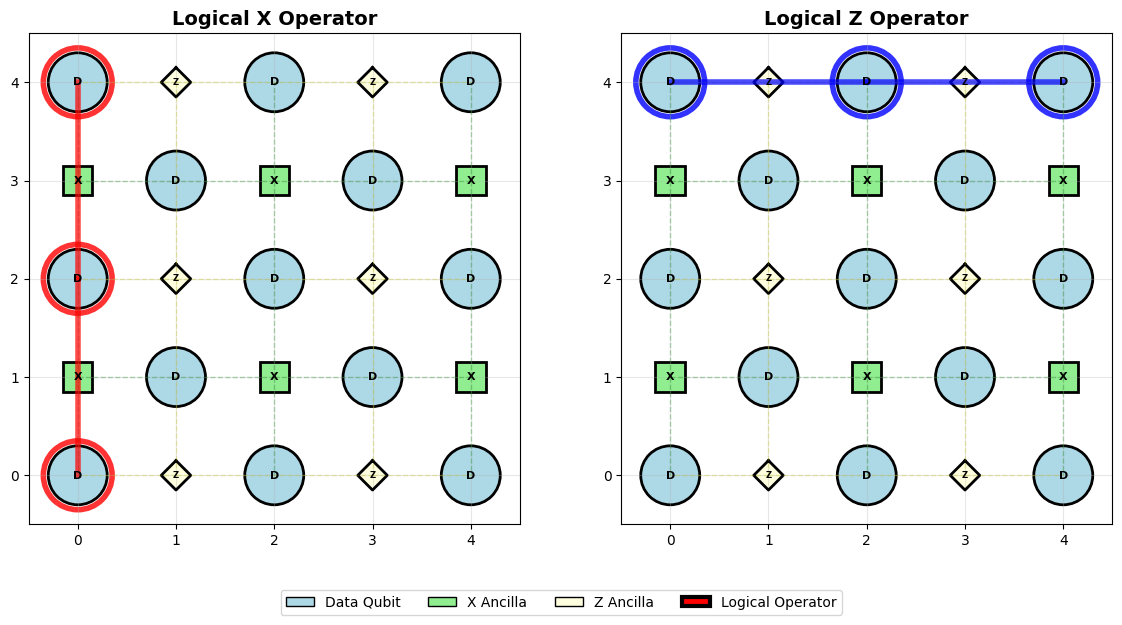


LOGICAL OPERATORS ANALYSIS
Number of logical qubits encoded: 1
Distance: 3

Logical X operators:
  X_1: 3 qubits
       Path: [(0, 0), (2, 0), (4, 0)]
       Description: Vertical string from top to bottom

Logical Z operators:
  Z_1: 3 qubits
       Path: [(0, 0), (0, 2), (0, 4)]
       Description: Horizontal string from left to right

Anticommutation check:
  Logical X and Z paths overlap at: 1 qubits
  Overlap positions: [(0, 0)]
  Anticommutation: Verified


In [6]:
distance = 3 # can change to distance 5
logical_ops = LogicalOperators(distance)
logical_ops.visualize_logical_operators()

## <font color='blue'>Injecting errors</font>

To observe the syndrome extraction circuits in action, we will need to inject errors at specific locations. We will enable three different kinds of errors:

1. Random Pauli errors on data qubits mimicking depolarizing error (randomly choosing one of $X$, $Y$ or $Z$).
2. Specifically defined errors at specific positions (eg $X$ error on qubit at grid location $(i,j)$.)
3. Logical errors that run from one end of the surface code to another

In [7]:
class ErrorInjection(LogicalOperators):
    """
    Inject errors in the surface code and visualise the errors.
    1. Inject random Pauli errors on data qubits ~like a depolarizing error.
    2. Inject by hand specific errors at given positions.
    3. Create logical errors.
    """
    
    def __init__(self, distance: int):
        super().__init__(distance)
        self.x_errors = set()  # Positions with X errors (bit flips)
        self.z_errors = set()  # Positions with Z errors (phase flips)
        self.y_errors = set()  # Positions with Y errors (both X and Z)
        self.error_syndrome_x = {}  # X syndrome measurements
        self.error_syndrome_z = {}  # Z syndrome measurements
    
    def inject_random_errors(self, error_rate = 0.1, seed = None):
        """
        Inject random Pauli errors on data qubits. 
        This is a heuristic implementation of depolarizing noise.
        """
        if seed is not None:
            random.seed(seed)
        
        # Clear previous errors
        self.x_errors.clear()
        self.z_errors.clear()
        self.y_errors.clear()
        
        for pos in self.data_qubits:
            if random.random() < error_rate:
                # Choose error type: (X, Z, or Y) ~ depolarizing error
                error_type = random.choice(['X', 'Z', 'Y'])
                
                if error_type == 'X':
                    self.x_errors.add(pos)
                elif error_type == 'Z':
                    self.z_errors.add(pos)
                else:  # Y error
                    self.y_errors.add(pos)
        
        # Calculate syndromes
        self._calculate_syndromes()
        
        print(f"Errors with rate {error_rate}:")
        print(f"  X errors: {len(self.x_errors)} at positions {sorted(self.x_errors)}")
        print(f"  Z errors: {len(self.z_errors)} at positions {sorted(self.z_errors)}")
        print(f"  Y errors: {len(self.y_errors)} at positions {sorted(self.y_errors)}")
        print(f"  Total errors: {len(self.x_errors) + len(self.z_errors) + len(self.y_errors)}")
    
    def inject_specific_errors(self, x_positions=None, z_positions=None, y_positions=None):
        """
        Add specific errors at given positions.
        """
        # Clear previous errors
        self.x_errors.clear()
        self.z_errors.clear()
        self.y_errors.clear()
        
        if x_positions:
            for pos in x_positions:
                if pos in self.data_qubits:
                    self.x_errors.add(pos)
        
        if z_positions:
            for pos in z_positions:
                if pos in self.data_qubits:
                    self.z_errors.add(pos)
        
        if y_positions:
            for pos in y_positions:
                if pos in self.data_qubits:
                    self.y_errors.add(pos)
        
        # Calculate syndromes
        self._calculate_syndromes()
        
        print(f"Specific errors introduced:")
        print(f"  X errors: {len(self.x_errors)} at positions {sorted(self.x_errors)}")
        print(f"  Z errors: {len(self.z_errors)} at positions {sorted(self.z_errors)}")
        print(f"  Y errors: {len(self.y_errors)} at positions {sorted(self.y_errors)}")
    
    def _calculate_syndromes(self):
        """
        Calculate syndrome measurements based on current errors.
        """
        # Calculate X syndromes (detect Z errors)
        self.error_syndrome_x = {}
        for ancilla_pos, data_positions in self.x_stabilizers.items():
            syndrome = 0
            for data_pos in data_positions:
                # X stabilizer detects Z errors and Y errors (Y=XZ)
                if data_pos in self.z_errors or data_pos in self.y_errors:
                    syndrome ^= 1
            self.error_syndrome_x[ancilla_pos] = syndrome
        
        # Calculate Z syndromes (detect X errors)
        self.error_syndrome_z = {}
        for ancilla_pos, data_positions in self.z_stabilizers.items():
            syndrome = 0
            for data_pos in data_positions:
                # Z stabilizer detects X errors and Y errors (Y=XZ)
                if data_pos in self.x_errors or data_pos in self.y_errors:
                    syndrome ^= 1
            self.error_syndrome_z[ancilla_pos] = syndrome
    
    def visualize_errors(self, show_syndromes=True):
        """
        Visualize the surface code with errors and syndromes.
        
        """
        if show_syndromes:
            fig, axes = plotter.subplots(1, 3, figsize=(21, 7))
        else:
            fig, axes = plotter.subplots(1, 1, figsize=(10, 8))
            axes = [axes]
        
        size = 2 * self.distance - 1
        
        # Plot random errors
        ax1 = axes[0]
        self._plot_errors_layout(ax1, size, show_syndromes=False)
        ax1.set_title(f'Surface Code with Errors', fontsize=14, fontweight='bold')
        
        if show_syndromes:
            # X syndromes
            ax2 = axes[1]
            self._plot_errors_layout(ax2, size, syndrome_type='X')
            ax2.set_title(f'X Syndromes (Detect Z/Y Errors)', fontsize=14, fontweight='bold')
            
            # Z syndromes
            ax3 = axes[2]
            self._plot_errors_layout(ax3, size, syndrome_type='Z')
            ax3.set_title(f'Z Syndromes (Detect X/Y Errors)', fontsize=14, fontweight='bold')
        
        for ax in axes:
            ax.set_xlim(-0.5, size-0.5)
            ax.set_ylim(-0.5, size-0.5)
            ax.set_aspect('equal')
            ax.grid(True, alpha=0.3)
        
        legend_elements = [
            Circle((0, 0), 0.1, color='lightblue', ec='black', label='Data Qubit'),
            Rectangle((0, 0), 0.1, 0.1, color='lightgreen', ec='black', label='X Ancilla'),
            Rectangle((0, 0), 0.1, 0.1, color='lightyellow', ec='black', label='Z Ancilla'),
            Circle((0, 0), 0.1, color='red', ec='black', linewidth=3, label='X Error'),
            Circle((0, 0), 0.1, color='blue', ec='black', linewidth=3, label='Z Error'),
            Circle((0, 0), 0.1, color='orange', ec='black', linewidth=3, label='Y Error'),
        ]
        
        if show_syndromes:
            legend_elements.extend([
                mpatches.Patch(color='purple', alpha=0.7, label='Triggered Syndrome'),
                mpatches.Patch(color='white', ec='black', label='Quiet Syndrome'),
            ])
        
        fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.02), ncol=4)
        plotter.tight_layout()
        plotter.subplots_adjust(bottom=0.15)
        plotter.show()
        
       
        self._print_syndrome_info()
    
    def _plot_errors_layout(self, ax, size, show_syndromes=True, syndrome_type=None):
        """
        Plot the surface code layout with errors and optionally syndromes.
        """
    
        self._plot_base_layout_errors(ax, size, syndrome_type)
        
        # Highlight errors on data qubits
        error_colors = {'X': 'red', 'Z': 'blue', 'Y': 'purple'}
        
        # Draw X errors
        for pos in self.x_errors:
            i, j = pos
            error_circle = Circle((j, size-1-i), 0.4, 
                                fill=False, ec=error_colors['X'], linewidth=4, alpha=0.9)
            ax.add_patch(error_circle)
            
            ax.text(j+0.3, size-1-i+0.3, 'X', ha='center', va='center', 
                   fontweight='bold', fontsize=10, color=error_colors['X'])
        
        # Draw Z errors
        for pos in self.z_errors:
            i, j = pos
            error_circle = Circle((j, size-1-i), 0.4, 
                                fill=False, ec=error_colors['Z'], linewidth=4, alpha=0.9)
            ax.add_patch(error_circle)
        
            ax.text(j+0.3, size-1-i+0.3, 'Z', ha='center', va='center', 
                   fontweight='bold', fontsize=10, color=error_colors['Z'])
        
        # Draw Y errors
        for pos in self.y_errors:
            i, j = pos
            error_circle = Circle((j, size-1-i), 0.4, 
                                fill=False, ec=error_colors['Y'], linewidth=4, alpha=0.9)
            ax.add_patch(error_circle)
    
            ax.text(j+0.3, size-1-i+0.3, 'Y', ha='center', va='center', 
                   fontweight='bold', fontsize=10, color=error_colors['Y'])
    
    def _plot_base_layout_errors(self, ax, size, syndrome_type=None):
        """
        Plot the base surface code layout with syndrome highlighting.
        """
        for pos in self.data_qubits:
            i, j = pos
            color = 'lightblue'
            circle = Circle((j, size-1-i), 0.3, color=color, ec='black', linewidth=2)
            ax.add_patch(circle)
            ax.text(j, size-1-i, 'D', ha='center', va='center', fontweight='bold', fontsize=8)
        
        
        for pos in self.x_ancillas:
            i, j = pos
            
       
            if syndrome_type == 'X' and pos in self.error_syndrome_x:
                if self.error_syndrome_x[pos] == 1:
                    color = 'purple'  # Triggered syndrome
                    alpha = 0.9
                else:
                    color = 'lightgreen'  # Quiet syndrome
                    alpha = 0.7
            else:
                color = 'lightgreen'
                alpha = 1.0
            
            square = Rectangle((j-0.3/2, size-1-i-0.3/2), 0.3, 0.3, 
                             color=color, ec='black', linewidth=2)
            ax.add_patch(square)
            ax.text(j, size-1-i, 'X', ha='center', va='center', fontweight='bold', fontsize=8)
            
            # Add syndrome value if showing syndromes
            if syndrome_type == 'X' and pos in self.error_syndrome_x:
                syndrome_val = self.error_syndrome_x[pos]
                ax.text(j+0.35, size-1-i+0.35, str(syndrome_val), ha='center', va='center', 
                       fontweight='bold', fontsize=12, color='purple' if syndrome_val else 'green',
                       bbox=dict(facecolor='black', alpha=0.2, edgecolor='white'))
        
        
        for pos in self.z_ancillas:
            i, j = pos
            if syndrome_type == 'Z' and pos in self.error_syndrome_z:
                if self.error_syndrome_z[pos] == 1:
                    color = 'purple'  # Triggered syndrome
                    alpha = 0.9
                else:
                    color = 'lightyellow'  # Quiet syndrome
                    alpha = 0.7
            else:
                color = 'lightyellow'
                alpha = 1.0
            
            diamond_x = [j, j+0.25, j, j-0.25, j]
            diamond_y = [size-1-i+0.25, size-1-i, size-1-i-0.25, size-1-i, size-1-i+0.25]
            ax.plot(diamond_x, diamond_y, 'k-', linewidth=2)
            ax.fill(diamond_x, diamond_y, color=color, alpha=alpha)
            ax.text(j, size-1-i, 'Z', ha='center', va='center', fontweight='bold', fontsize=6)
            
            # Add syndrome value if showing syndromes
            if syndrome_type == 'Z' and pos in self.error_syndrome_z:
                syndrome_val = self.error_syndrome_z[pos]
                ax.text(j+0.35, size-1-i+0.35, str(syndrome_val), ha='center', va='center', 
                       fontweight='bold', fontsize=12, color='purple'if syndrome_val else 'green',
                       bbox=dict(facecolor='black', alpha=0.2, edgecolor='white'))
        
       
        if syndrome_type != 'X':
            for pos, data_qubits_list in self.x_stabilizers.items():
                i, j = pos
                for di, dj in data_qubits_list:
                    ax.plot([j, dj], [size-1-i, size-1-di], 'g--', alpha=0.2, linewidth=1)
        
        if syndrome_type != 'Z':
            for pos, data_qubits_list in self.z_stabilizers.items():
                i, j = pos
                for di, dj in data_qubits_list:
                    ax.plot([j, dj], [size-1-i, size-1-di], 'y--', alpha=0.2, linewidth=1)
    
    def _print_syndrome_info(self):
        """Syndrome information."""
        print("\n" + "="*60)
        print("SYNDROME MEASUREMENT RESULTS")
        print("="*60)
        
        # Count triggered syndromes
        x_triggered = sum(1 for syndrome in self.error_syndrome_x.values() if syndrome == 1)
        z_triggered = sum(1 for syndrome in self.error_syndrome_z.values() if syndrome == 1)
        
        print(f"X syndromes: {x_triggered}/{len(self.error_syndrome_x)} triggered")
        print(f"Z syndromes: {z_triggered}/{len(self.error_syndrome_z)} triggered")
        
        # Print triggered syndromes
        print(f"\nTriggered X syndromes (detect Z/Y errors):")
        for pos, syndrome in self.error_syndrome_x.items():
            if syndrome == 1:
                print(f"  Ancilla at {pos}: syndrome = {syndrome}")
        
        print(f"\nTriggered Z syndromes (detect X/Y errors):")
        for pos, syndrome in self.error_syndrome_z.items():
            if syndrome == 1:
                print(f"  Ancilla at {pos}: syndrome = {syndrome}")
        
        # Check if logical operators are affected
        self._check_logical_flips()
    
    def _check_logical_flips(self):
        """
        Check if logical flips occurred (anticommuting with the logical operators)
        """
        print(f"\nLogical flip analysis:")
        
        # Check logical X operator (affected by Z errors)
        logical_x_errors = 0
        for pos in self.logical_x_operators[0]:
            if pos in self.z_errors or pos in self.y_errors:
                logical_x_errors += 1
        
        # Check logical Z operator (affected by X errors)
        logical_z_errors = 0
        for pos in self.logical_z_operators[0]:
            if pos in self.x_errors or pos in self.y_errors:
                logical_z_errors += 1
        
        print(f"  Logical X operator: {logical_x_errors} errors")
        print(f"  Logical Z operator: {logical_z_errors} errors")
        
        # Determine if logical error occurred
        logical_x_flipped = logical_x_errors % 2 == 1
        logical_z_flipped = logical_z_errors % 2 == 1
        
        print(f"  Logical X flipped: {'Yes' if logical_x_flipped else 'No'}")
        print(f"  Logical Z flipped: {'Yes' if logical_z_flipped else 'No'}")
        
        if logical_x_flipped or logical_z_flipped:
            print(f"LOGICAL FLIP DETECTED!")
        else:
            print(f"No logical flips")

### <font color='red'>Injecting errors into distance-3 surface codes</font>

In [8]:
distance = 3
error_sim = ErrorInjection(distance = distance)

#### Example 1: Inject random errors and observe the syndrome checks that fire

Errors with rate 0.05:
  X errors: 2 at positions [(3, 1), (4, 2)]
  Z errors: 1 at positions [(0, 2)]
  Y errors: 0 at positions []
  Total errors: 3


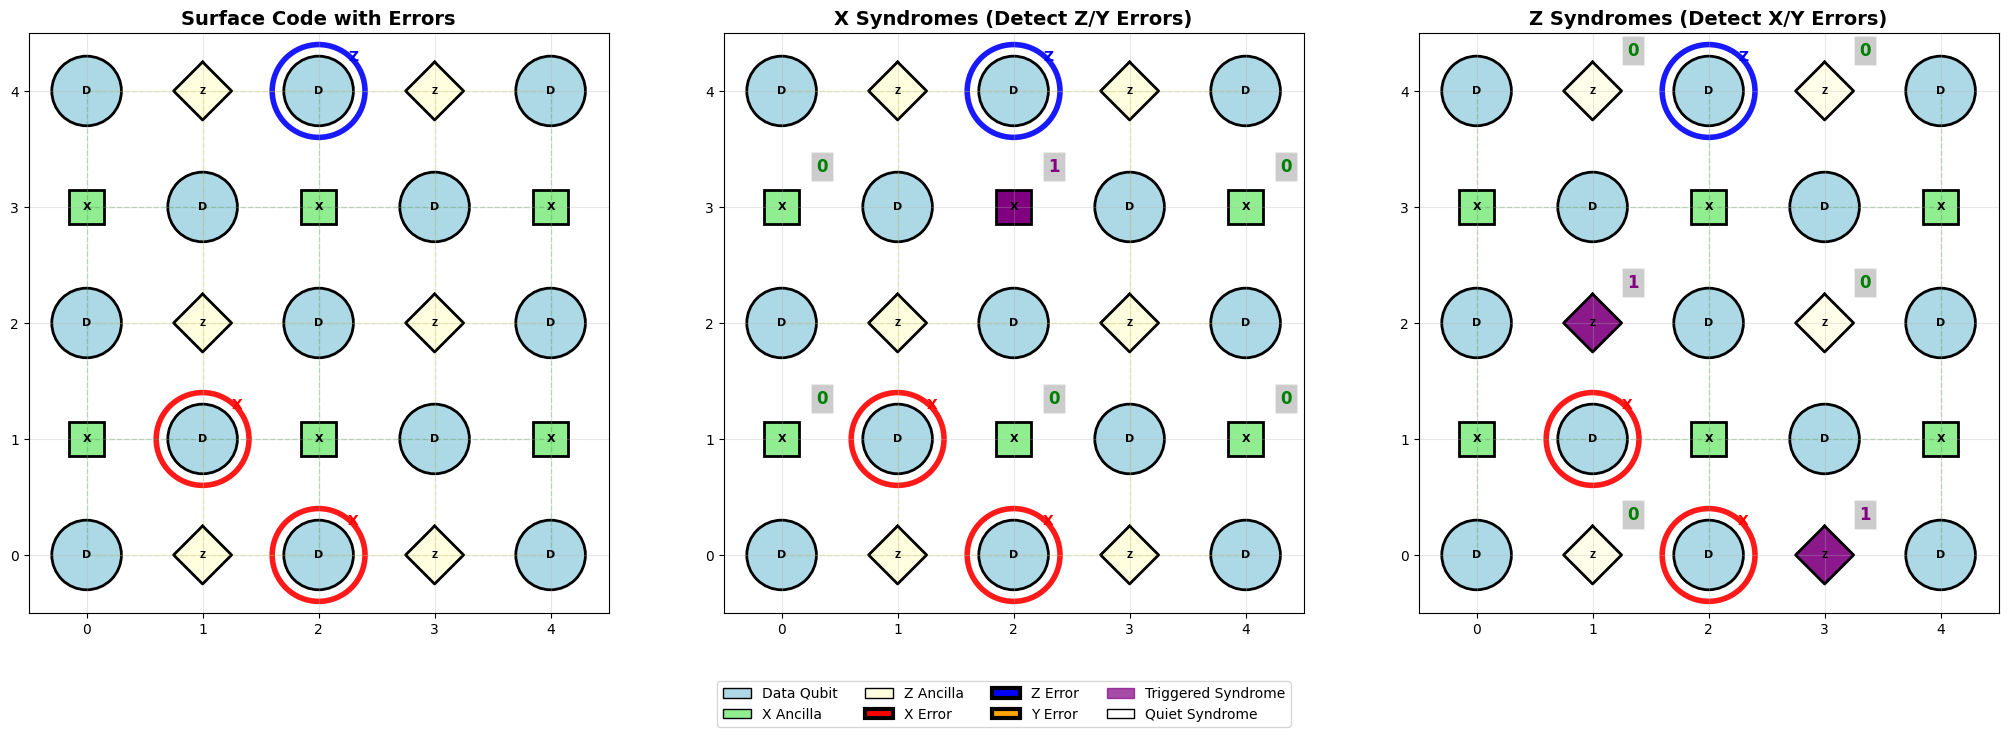


SYNDROME MEASUREMENT RESULTS
X syndromes: 1/6 triggered
Z syndromes: 2/6 triggered

Triggered X syndromes (detect Z/Y errors):
  Ancilla at (1, 2): syndrome = 1

Triggered Z syndromes (detect X/Y errors):
  Ancilla at (2, 1): syndrome = 1
  Ancilla at (4, 3): syndrome = 1

Logical flip analysis:
  Logical X operator: 0 errors
  Logical Z operator: 0 errors
  Logical X flipped: No
  Logical Z flipped: No
No logical flips


In [9]:
error_sim.inject_random_errors(error_rate=0.05, seed=42)
error_sim.visualize_errors()

#### Example 2: Inject even or odd errors in a chain

When we inject an odd number of errors in the logical path, they do not commute with the logical operator. For example, let's imagine that the logical operator $Z_L$ is $Z_L = Z_1Z_2Z_3$. That means

$$
Z_L\vert\psi\rangle_L = +1\vert\psi\rangle_L
$$

If an $X_1$ error is injected, then the logical state $\vert\psi\rangle_L$, becomes $X_1\vert\psi\rangle_L$. Now, this new state is related to the logical operator differently:

$$
Z_LX_1\vert\psi\rangle_L = Z_1Z_2Z_3X_1\vert\psi\rangle_L = -X_1Z_1Z_2Z_3\vert\psi\rangle_L = -X_1\vert\psi\rangle_L
$$

and we see that it is now a $-1$ eigenstate of $Z_L$. This implies that the logical state $\vert\psi\rangle_L$ has flipped, and it is now the opposite eigenstate of the logical operator with eigenvalue $-1$.

Similarly, when we inject an even number of errors in the logical path, they commute with the logical operator, with does not lead to a logical flip.

Specific errors introduced:
  X errors: 1 at positions [(0, 0)]
  Z errors: 0 at positions []
  Y errors: 0 at positions []


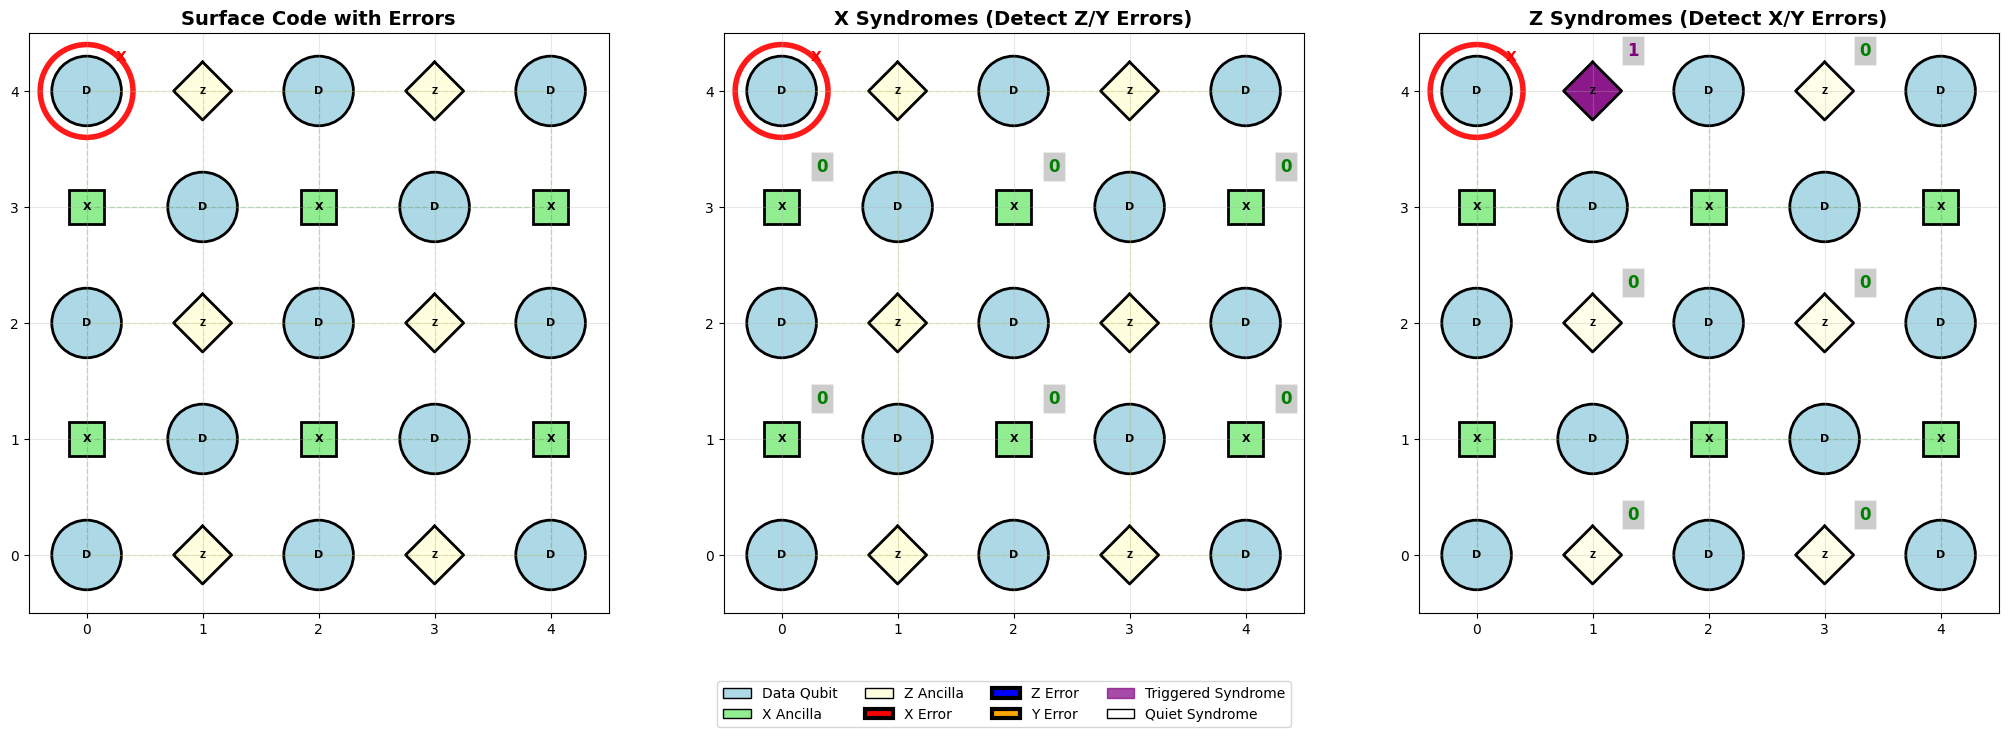


SYNDROME MEASUREMENT RESULTS
X syndromes: 0/6 triggered
Z syndromes: 1/6 triggered

Triggered X syndromes (detect Z/Y errors):

Triggered Z syndromes (detect X/Y errors):
  Ancilla at (0, 1): syndrome = 1

Logical flip analysis:
  Logical X operator: 0 errors
  Logical Z operator: 1 errors
  Logical X flipped: No
  Logical Z flipped: Yes
LOGICAL FLIP DETECTED!


In [10]:
# Inject 1 X errors along logical Z operator -- no logical flip ()
logical_z_path = error_sim.logical_z_operators[0]
error_positions = logical_z_path[:1]
error_sim.inject_specific_errors(x_positions=error_positions)
error_sim.visualize_errors()

Specific errors introduced:
  X errors: 2 at positions [(0, 0), (0, 2)]
  Z errors: 0 at positions []
  Y errors: 0 at positions []


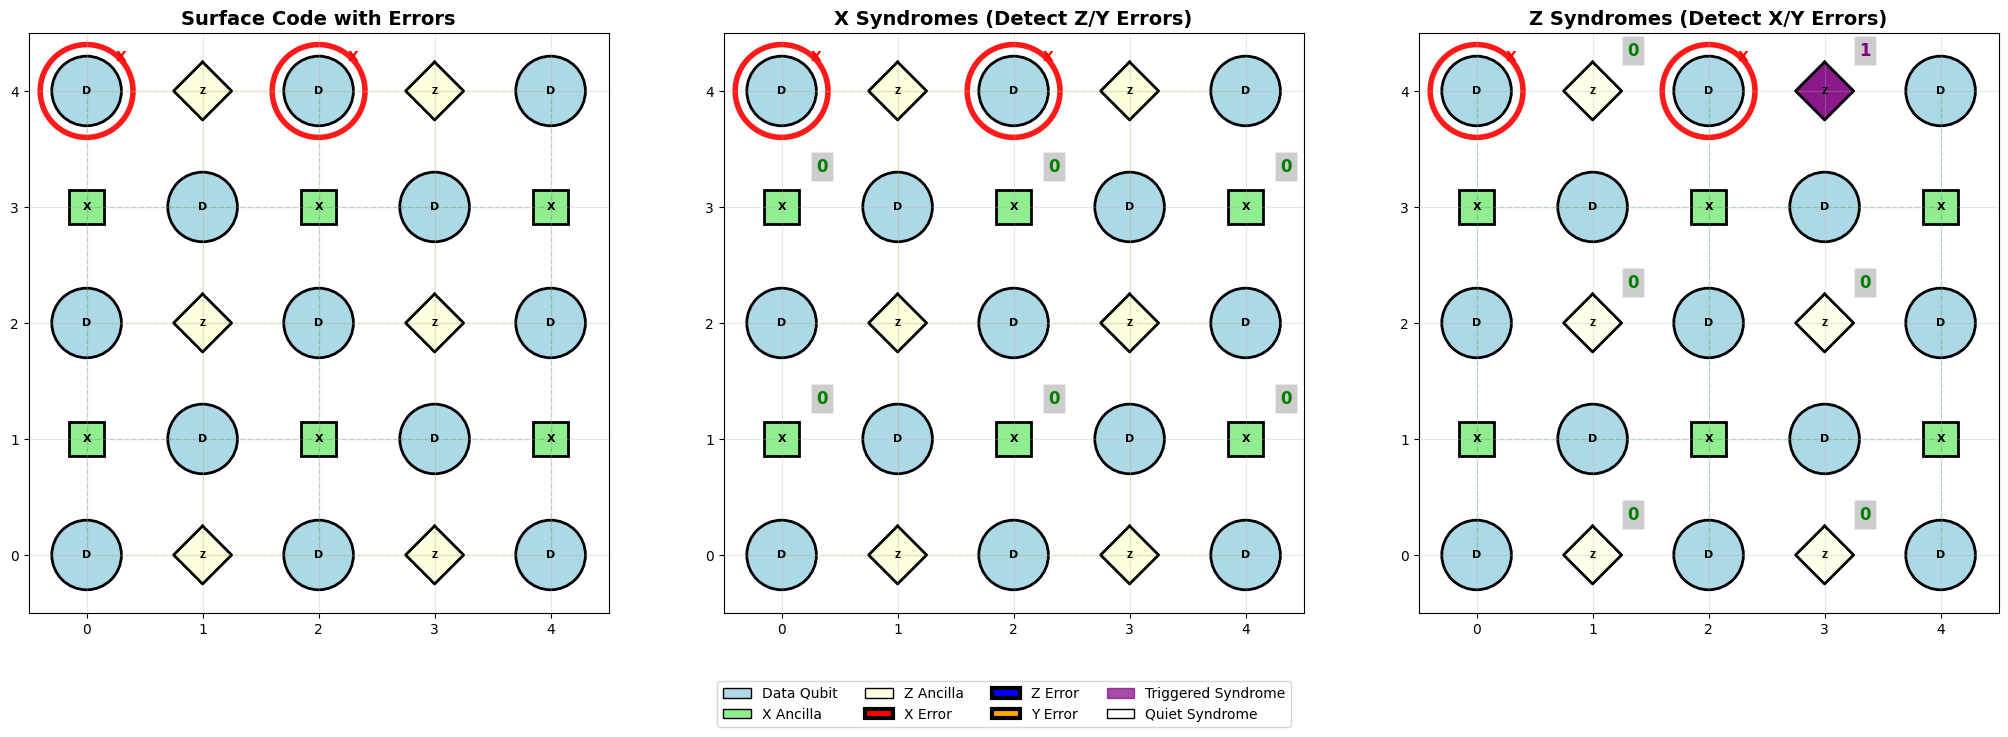


SYNDROME MEASUREMENT RESULTS
X syndromes: 0/6 triggered
Z syndromes: 1/6 triggered

Triggered X syndromes (detect Z/Y errors):

Triggered Z syndromes (detect X/Y errors):
  Ancilla at (0, 3): syndrome = 1

Logical flip analysis:
  Logical X operator: 0 errors
  Logical Z operator: 2 errors
  Logical X flipped: No
  Logical Z flipped: No
No logical flips


In [11]:
# Inject 2 X errors along logical Z operator -- no logical flip
logical_z_path = error_sim.logical_z_operators[0]
error_positions = logical_z_path[:2]
error_sim.inject_specific_errors(x_positions=error_positions)
error_sim.visualize_errors()

Specific errors introduced:
  X errors: 3 at positions [(0, 0), (0, 2), (0, 4)]
  Z errors: 0 at positions []
  Y errors: 0 at positions []


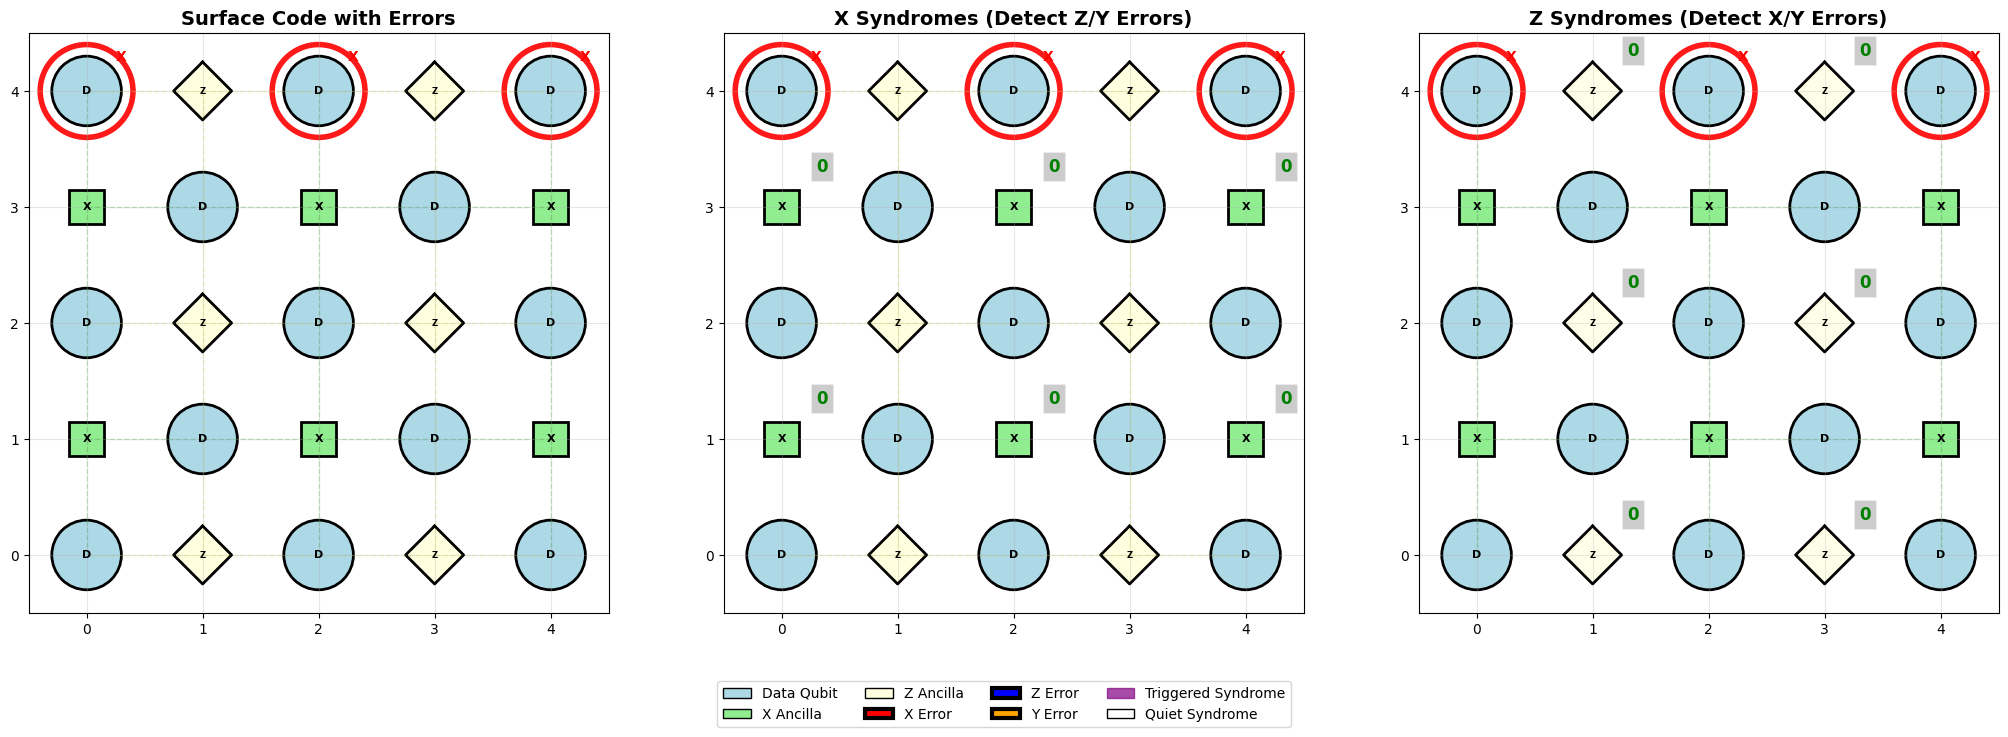


SYNDROME MEASUREMENT RESULTS
X syndromes: 0/6 triggered
Z syndromes: 0/6 triggered

Triggered X syndromes (detect Z/Y errors):

Triggered Z syndromes (detect X/Y errors):

Logical flip analysis:
  Logical X operator: 0 errors
  Logical Z operator: 3 errors
  Logical X flipped: No
  Logical Z flipped: Yes
LOGICAL FLIP DETECTED!


In [12]:
# Inject 3 X errors along logical Z operator -- logical flip since end to end
error_positions = logical_z_path
error_sim.inject_specific_errors(x_positions=error_positions)
error_sim.visualize_errors()

## <font color='blue'>Recap</font>

Let's recap what we have learned so far. 
1. We introduced the planar surface code, and how the data and ancilla qubits are laid out.
2. We built syndrome extraction circuits to measure stabilizers using the ancilla qubits. These circuits were analogous to those used with repetition codes, but are carefully arranged since the surface code is a 2D setup.
3. We learned about logical operators.
4. We simulated syndrome extraction circuits using simple noise models.
5. We visualized the errors on the planar surface code.

## <font color='blue'>Next steps</font>

We used a very simplistic noise model to demonstrate syndrome checks in action. However, in practice, you would use a noise model that more closely resembles the measured qubit noise on the real quantum system in consideration.

In the next section, we will learn how to decode these errors and make plots that show the code threshold, similar to the journey with repetition codes in earlier chapters. Instead of building this functionality ourselves, we will start using `stim`, and implement our work using the rotated surface code. `stim` can automatically generate the syndrome extraction circuits for us, and we will use the detector error model from `stim` to decode errors using `pymatching`. 